In [486]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import missingno as msno

players = pd.read_csv('./Dataset/players.csv')
teams = pd.read_csv('./Dataset/teams.csv')
players_teams = pd.read_csv('./Dataset/players_teams.csv')
awards_players = pd.read_csv('./Dataset/awards_players.csv')
coaches = pd.read_csv('./Dataset/coaches.csv')
series_post = pd.read_csv('./Dataset/series_post.csv')
teams_post = pd.read_csv('./Dataset/teams_post.csv')



### Awards_players


- corrected name of a prize
- drop lgID
- calculate the number of prizes that each player has (having in consideration the year)
- drop award (name)

In [487]:
awards_players['award'] = awards_players['award'].replace("Kim Perrot Sportsmanship", "Kim Perrot Sportsmanship Award")
awards_players = awards_players.drop(columns=['lgID'], axis=1)

award_weights = {
    "All-Star Game Most Valuable Player": 2,
    "Coach of the Year": 3,
    "Defensive Player of the Year": 4,
    "Kim Perrot Sportsmanship Award": 1,
    "Most Improved Player": 2,
    "Most valuable Player": 5,
    "Rookie of the Year": 3,
    "Sixth Woman of the Year": 2,
    "WNBA Finals Most Valuable Player": 4,
    "WNBA All-Decade Team": 1,
    "WNBA All Decade Team Honorable Mention": 1,
}

# Sort the DataFrame by playerID and year
awards_players.sort_values(by=["playerID", "year"], inplace=True)

awards_players['award_weight'] = awards_players['award'].map(award_weights)
awards_players['num_prizes'] = awards_players.groupby('playerID')['award_weight'].cumsum()

#awards_players['num_prizes'] = awards_players.groupby('playerID').cumcount() + 1

awards_players = awards_players.drop(columns=['award', 'award_weight'], axis=1)

awards_players.to_csv('./Modified/modified_awards.csv', index=False)


### Players

- drop college, collegeOther, pos and lastseason
- remove who has height = 0
- replace height error (9) with the average
- replace weight error (0) with the average


In [488]:
players = players.drop('college', axis=1)
players = players.drop('pos', axis=1)
players = players.drop('collegeOther', axis=1)
# Have only 0s
players = players.drop('lastseason', axis=1)
players = players.drop('firstseason', axis=1)

players = players[players['height'] > 0]

# Calculate the mean of non-zero heights
mean_height = players[(players['height'] != 0) | (players['height'] != 9)]['height'].mean()
# Replace 9 with the mean height
players['height'] = players['height'].replace(9, mean_height)

# Calculate the mean of non-zero weights
mean_weight = players[players['weight'] != 0]['weight'].mean()
players['weight'] = players['weight'].replace(0, mean_weight)



In [489]:
#players_teams = players_teams.drop('lgID', axis=1)
df = players_teams

df = df.sort_values(by=['playerID', 'year', 'stint'])
columns_to_shift = df.columns.difference(['playerID', 'year', 'stint', 'tmID', 'lgID'])

# Shifting the columns other than "playerID", "year", "stint", "tmID", and "lgID"
df[columns_to_shift] = df.groupby('playerID')[columns_to_shift].shift(fill_value=None)

first_year_mask = df['year'] == df.groupby('playerID')['year'].transform('min')
df.loc[first_year_mask, columns_to_shift] = None
df.to_csv('./Modified/modified_players_teams.csv', index=False)


- add a column called Age, considering the year of the season. Calculated through the merge between two datasets
- drop birthdate and deathdate


In [490]:
def calculate_age(row):
    birth_year = int(row['birthDate'][:4])
    age = 2000 + row['year'] - birth_year
    return age


merged_data = players.merge(players_teams, left_on='bioID', right_on='playerID')

merged_data = merged_data.merge(awards_players, left_on=['bioID', 'year'], right_on=['playerID', 'year'], how='left')
merged_data.sort_values(by=["bioID", "year"], inplace=True)

merged_data['num_prizes'] = merged_data.groupby('bioID')['num_prizes'].ffill()

# Fill NaN values with 0 for players with no prizes 
merged_data['num_prizes'].fillna(0, inplace=True)

# Apply the function to each row
merged_data['age'] = merged_data.apply(calculate_age, axis=1)

merged_data = merged_data.drop('birthDate', axis=1)
merged_data = merged_data.drop('deathDate', axis=1)
merged_data = merged_data.drop('playerID_x', axis=1)
merged_data = merged_data.drop('playerID_y', axis=1)


### Coaches

- drop lgID, stint, post_wins and post_losses
- create column num_prizes (merging awards_players)

In [491]:
coaches = coaches.drop(columns=['lgID'], axis=1)
coaches = coaches.drop(columns=['stint'], axis=1)
coaches = coaches.drop(columns=['post_wins'], axis=1)
coaches = coaches.drop(columns=['post_losses'], axis=1)

coaches = coaches.merge(awards_players, left_on=['coachID', 'year'], right_on=['playerID', 'year'], how='left')
coaches.sort_values(by=["coachID", "year"], inplace=True)

coaches['num_prizes'] = coaches.groupby('coachID')['num_prizes'].ffill()

# Fill NaN values with 0 for players with no prizes 
coaches['num_prizes'].fillna(0, inplace=True)

coaches = coaches.drop(columns=['playerID'], axis=1)


### Teams

- drop seeded, confID, divID, franchID, arena, lgID and name
- corrected error: one season it was registered two winners

In [492]:

teams = teams.drop(columns=['seeded'], axis=1)
teams = teams.drop(columns=['divID'], axis=1)
teams = teams.drop(columns=['franchID'], axis=1)
teams = teams.drop(columns=['arena'], axis=1)
teams = teams.drop(columns=['lgID'], axis=1)
teams = teams.drop(columns=['name'], axis=1)
teams = teams.drop(columns=['tmORB'], axis=1)
teams = teams.drop(columns=['tmDRB'], axis=1)
teams = teams.drop(columns=['tmTRB'], axis=1)
teams = teams.drop(columns=['opptmORB'], axis=1)
teams = teams.drop(columns=['opptmDRB'], axis=1)
teams = teams.drop(columns=['opptmTRB'], axis=1)
teams = teams.drop(columns=['rank'], axis=1)
teams = teams.drop(columns=['firstRound'], axis=1)
teams = teams.drop(columns=['semis'], axis=1)
teams = teams.drop(columns=['finals'], axis=1)


# In the year 6, a victory was incorrectly recorded.
#teams.loc[(teams['year'] == 6) & (teams['tmID'] == 'CON'), 'finals'] = 'L'


- calculate the number of prizes a team has (total of prizes the players have), creating the column num_prizes

In [493]:

playerAndTeams = merged_data.merge(teams, on=["tmID", "year"])


# Group by team and year, summing the number of prizes
team_prizes = playerAndTeams.groupby(['tmID', 'year'])['num_prizes'].sum().reset_index()

# Sort the result by year
team_prizes.sort_values(by='year', ascending=True, inplace=True)
print(team_prizes)

teams = teams.merge(team_prizes, on=["tmID", "year"])


    tmID  year  num_prizes
63   MIA     1         0.0
24   DET     1         0.0
89   PHO     1         0.0
129  UTA     1         0.0
99   POR     1         0.0
..   ...   ...         ...
75   MIN    10         7.0
85   NYL    10         2.0
98   PHO    10        21.0
52   IND    10        26.0
141  WAS    10         2.0

[142 rows x 3 columns]


- add to the table teams the number of prizes the coach has (sum it in the column num_prizes)

In [494]:
""" teams = pd.merge(teams, coaches[['tmID', 'year', 'won', 'lost']], on=['tmID', 'year'], how='left')

teams = teams.rename(columns={'won_y': 'coach_won', 'lost_y': 'coach_lost'})

print(teams) """

""" merged_df = pd.merge(teams, coaches, on=['year', 'tmID'], how='left')

merged_df['num_prizes_y'] = merged_df['num_prizes_y'].fillna(0)

merged_df['num_prizes'] = merged_df['num_prizes_x'] + merged_df['num_prizes_y']

merged_df = merged_df.drop(['num_prizes_x', 'num_prizes_y'], axis=1)

# Update the 'num_prizes' column in the original teams DataFrame
teams['num_prizes'] = merged_df['num_prizes'] """

In [495]:
""" winners = teams[teams['finals'] == 'W']
losers = teams[teams['finals'] == 'L']

# Plotting
plt.bar(winners['year'], winners['num_prizes'], label='Winners')
plt.bar(losers['year'], losers['num_prizes'], label='Losers')

# Adding labels and title
plt.xlabel('Year')
plt.ylabel('Number of Prizes')
plt.title('Number of Prizes: Winners vs Losers')
plt.legend()

# Show the plot
plt.show()
 """


" winners = teams[teams['finals'] == 'W']\nlosers = teams[teams['finals'] == 'L']\n\n# Plotting\nplt.bar(winners['year'], winners['num_prizes'], label='Winners')\nplt.bar(losers['year'], losers['num_prizes'], label='Losers')\n\n# Adding labels and title\nplt.xlabel('Year')\nplt.ylabel('Number of Prizes')\nplt.title('Number of Prizes: Winners vs Losers')\nplt.legend()\n\n# Show the plot\nplt.show()\n "

In [496]:
merged_data = pd.merge(merged_data, teams, on=['year', 'tmID'], how='inner')
team_means = merged_data.groupby(['tmID', 'year']).agg({
    'height': 'mean',
    'weight': 'mean',
    'age': 'mean',
}).reset_index()
teams = pd.merge(teams, team_means, on=['tmID', 'year'], how='left')


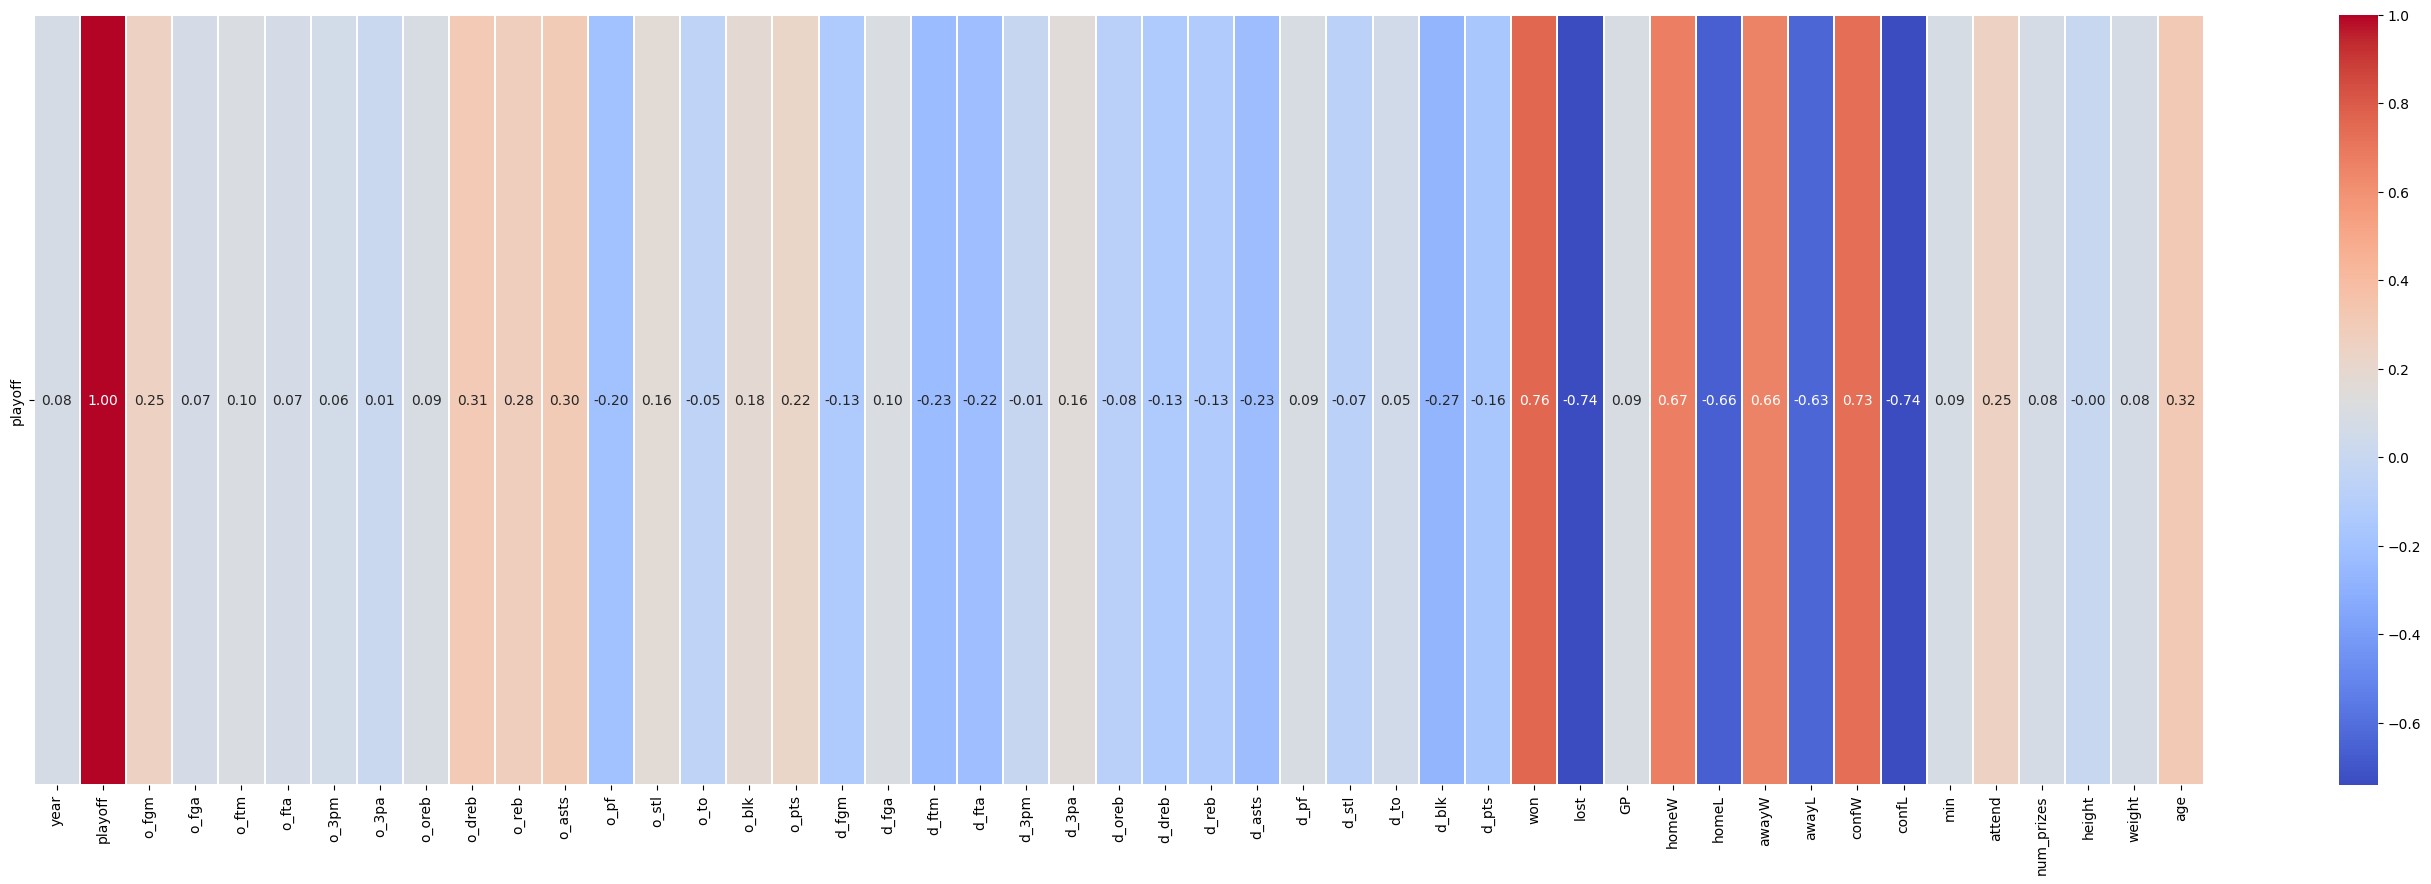

In [497]:
df = teams[['year','playoff','o_fgm', 'o_fga', 'o_ftm', 'o_fta', 'o_3pm', 'o_3pa', 'o_oreb', 'o_dreb', 'o_reb', 'o_asts', 'o_pf', 'o_stl', 'o_to', 'o_blk', 'o_pts', 'd_fgm', 'd_fga', 'd_ftm', 'd_fta', 'd_3pm', 'd_3pa', 'd_oreb', 'd_dreb', 'd_reb', 'd_asts', 'd_pf', 'd_stl', 'd_to', 'd_blk', 'd_pts', 'won', 'lost', 'GP', 'homeW', 'homeL', 'awayW', 'awayL', 'confW', 'confL', 'min', 'attend', 'num_prizes', 'height', 'weight', 'age']]
df.loc[:, 'playoff'] = df['playoff'].replace({'N': 0, 'Y': 1})

# Calculate correlation matrix
correlation_matrix = df.corr()
# Display correlation matrix

plt.figure(figsize=(35, 10))
sns.heatmap(correlation_matrix[['playoff']].transpose(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=.3)
plt.show()

In [498]:
from sklearn.preprocessing import LabelEncoder

# Encode the 'playoff' column
label_encoder = LabelEncoder()
teams['playoff'] = label_encoder.fit_transform(teams['playoff'])
#teams['previous_playoff'] = label_encoder.fit_transform(teams['previous_playoff'])

teams = pd.get_dummies(teams, columns=['tmID', 'confID'])


train_data = teams[(teams['year'] >= 2) & (teams['year'] <= 9)]
test_data = teams[teams['year'] == 10]

X_train = train_data.drop(['playoff'], axis=1)
y_train = train_data['playoff']

X_test = test_data.drop(['playoff'], axis=1)
y_test = test_data['playoff']

clf = DecisionTreeClassifier()

# Fit the classifier on the training data
clf.fit(X_train, y_train)

# Make predictions on the test set
predictions = clf.predict(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

Accuracy: 0.6153846153846154


In [499]:
teams.to_csv('./Modified/modified_teams.csv', index=False)
merged_data.to_csv('./Modified/players_playersTeams.csv', index=False)
coaches.to_csv('./Modified/modified_coaches.csv', index=False)